### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import value_counts
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

### Import data

In [2]:
df = sns.load_dataset("titanic")

### Data Understanding

In [3]:
df.shape

(891, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [5]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
389,1,2,female,17.0,0,0,12.0000,C,Second,woman,False,NaN,Cherbourg,yes,True
335,0,3,male,NaN,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True
843,0,3,male,34.5,0,0,6.4375,C,Third,man,True,NaN,Cherbourg,no,True
299,1,1,female,50.0,0,1,247.5208,C,First,woman,False,B,Cherbourg,yes,False
590,0,3,male,35.0,0,0,7.1250,S,Third,man,True,NaN,Southampton,no,True


### Data Wrangling

#### Missing Values

In [7]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

##### Understanding age to fill the most appropirate value

In [8]:
df[df["age"].isnull()]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
17,1,2,male,NaN,0,0,13.0000,S,Second,man,True,NaN,Southampton,yes,True
19,1,3,female,NaN,0,0,7.2250,C,Third,woman,False,NaN,Cherbourg,yes,True
26,0,3,male,NaN,0,0,7.2250,C,Third,man,True,NaN,Cherbourg,no,True
28,1,3,female,NaN,0,0,7.8792,Q,Third,woman,False,NaN,Queenstown,yes,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,0,3,male,NaN,0,0,7.2292,C,Third,man,True,NaN,Cherbourg,no,True
863,0,3,female,NaN,8,2,69.5500,S,Third,woman,False,NaN,Southampton,no,False
868,0,3,male,NaN,0,0,9.5000,S,Third,man,True,NaN,Southampton,no,True
878,0,3,male,NaN,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True


In [9]:
df.groupby(["who"])["age"].describe()

,count,mean,std,min,25%,50%,75%,max
who,,,,,,,,
child,83.0,6.369518,4.729063,0.42,2.0,5.0,9.5,15.0
man,413.0,33.173123,12.906908,16.00,23.0,30.0,40.0,80.0
woman,218.0,32.000000,11.495441,16.00,23.0,30.0,39.0,63.0


In [10]:
df.age.median()

28.0

In [11]:
df["age"].fillna(df.age.median(), inplace=True)

#### Outlier Detection and Removal

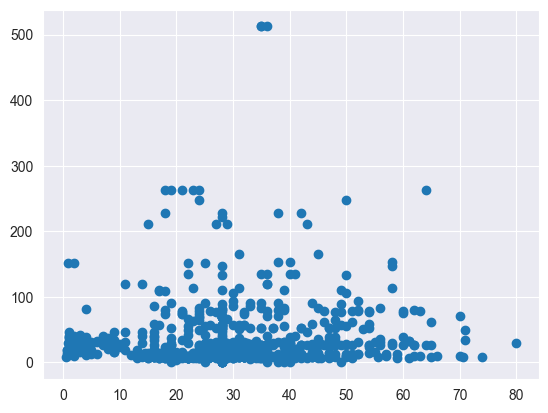

In [12]:
plt.scatter(df["age"], df["fare"])

{'whiskers': [<matplotlib.lines.Line2D at 0x23f90705410>,
 'caps': [<matplotlib.lines.Line2D at 0x23f90706990>,
 'boxes': [<matplotlib.lines.Line2D at 0x23f90704a50>,
 'medians': [<matplotlib.lines.Line2D at 0x23f90707b10>,
 'fliers': [<matplotlib.lines.Line2D at 0x23f90718410>,
 'means': []}

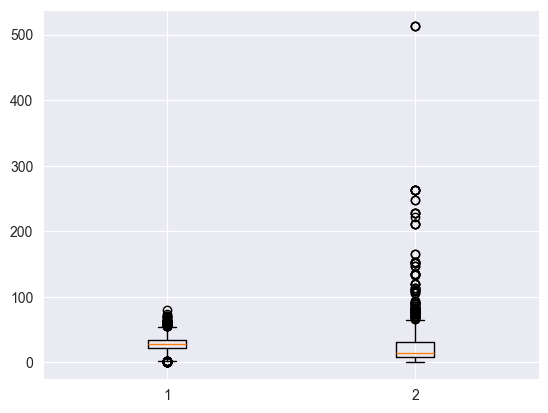

In [13]:
plt.boxplot(df[["age", "fare"]])

#### IQR Method(fare)

In [14]:
q1 = df['fare'].quantile(0.25)
q3 = df['fare'].quantile(0.75)
iqr = q3 - q1

low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr

df = df.loc[(df['fare'] > low) & (df['fare'] < high)].reset_index(drop=True)

#### IQR Method(age)

In [15]:
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)
iqr = q3 - q1

low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr

df = df.loc[(df['age'] > low) & (df['age'] < high)].reset_index(drop=True)

#### Column Equivalence

In [16]:
print(df["embarked"].unique(), df["embark_town"].unique())
df[["embarked", "embark_town"]].sample(5)

['S' 'Q' 'C'] ['Southampton' 'Queenstown' 'Cherbourg']


,embarked,embark_town
488,S,Southampton
210,S,Southampton
647,S,Southampton
590,S,Southampton
410,S,Southampton


In [17]:
print(df["pclass"].unique(), df["class"].unique())
df[["pclass", "class"]].sample(5)

[3 1 2] ['Third', 'First', 'Second']
Categories (3, object): ['First', 'Second', 'Third']


,pclass,class
43,3,Third
187,2,Second
315,3,Third
528,3,Third
304,2,Second


In [18]:
print(df["sibsp"].unique(), df["parch"].unique())
df[["sibsp", "parch"]].sample(15)

[1 0 3 2 4 5] [0 2 5 1 3 4 6]


,sibsp,parch
394,0,0
551,1,0
216,0,0
669,1,0
186,0,0
428,0,0
322,0,2
101,0,0
276,0,0
190,0,0


In [19]:
print(df["survived"].unique(), df["alive"].unique())
df[["survived", "alive"]].sample(5)

[0 1] ['no' 'yes']


,survived,alive
444,0,no
666,1,yes
527,0,no
4,0,no
619,0,no


#### Drop Features


In [20]:
# Dropping alone and adult_male because we can get same information from parch and who respectively
# deck contains high amount of missing values,
# embarked == embark_town, pclass == class, alive == survived
df.drop(columns = ["alone","deck","embarked", "adult_male", "class", "alive"], inplace=True)

#### Converting data types

In [21]:
# category
df[["embark_town", "sex", "who"]] = df[["embark_town", "sex", "who"]].astype("category")

# uint8
df[["pclass", "sibsp", "age", "parch", "survived"]] = df[["pclass", "sibsp", "age", "parch", "survived"]].astype("uint8")

# unit16
df[["fare"]] = df[["fare"]].astype("uint16")

### Exploratory Data Analysis

#### Collinearity

<Axes: >

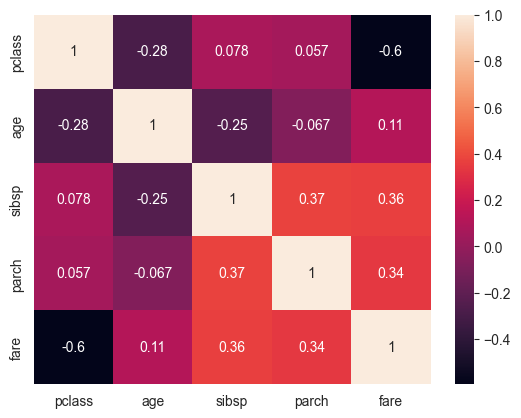

In [22]:
corr = df.select_dtypes("number").drop(columns=["survived"]).corr()
sns.heatmap(corr, annot=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     696 non-null    uint8   
 1   pclass       696 non-null    uint8   
 2   sex          696 non-null    category
 3   age          696 non-null    uint8   
 4   sibsp        696 non-null    uint8   
 5   parch        696 non-null    uint8   
 6   fare         696 non-null    uint16  
 7   who          696 non-null    category
 8   embark_town  696 non-null    category
dtypes: category(3), uint16(1), uint8(5)
memory usage: 7.3 KB


#### Data visualization

##### Survivors by Passenger Type

C:\Users\Shahzaib Khan\AppData\Local\Temp\ipykernel_9848\1246010431.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survivors_count = df[df["survived"] == True].groupby("who")["survived"].count()
C:\Users\Shahzaib Khan\AppData\Local\Temp\ipykernel_9848\1246010431.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  non_survivors_count = df[df["survived"] == False].groupby("who")["survived"].count()


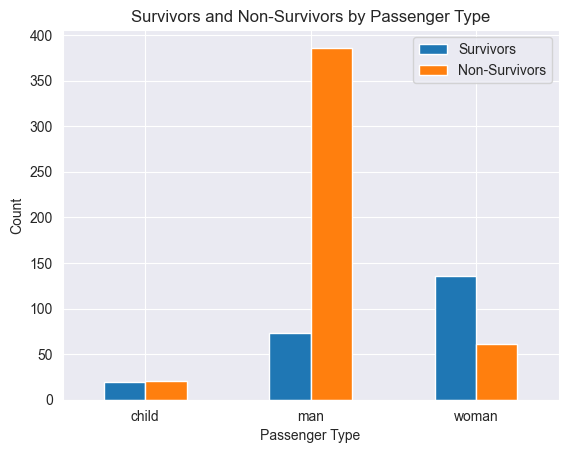

       Survivors  Non-Survivors
who                            
child         19             21
man           73            386
woman        136             61


In [24]:
survivors_count = df[df["survived"] == True].groupby("who")["survived"].count()
non_survivors_count = df[df["survived"] == False].groupby("who")["survived"].count()

combined_counts = pd.DataFrame({
    "Survivors": survivors_count,
    "Non-Survivors": non_survivors_count
})

combined_counts.plot(kind='bar')
plt.title("Survivors and Non-Survivors by Passenger Type")
plt.xlabel("Passenger Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()
print(combined_counts)

##### Survivors & Non-Survivor by Embark Town


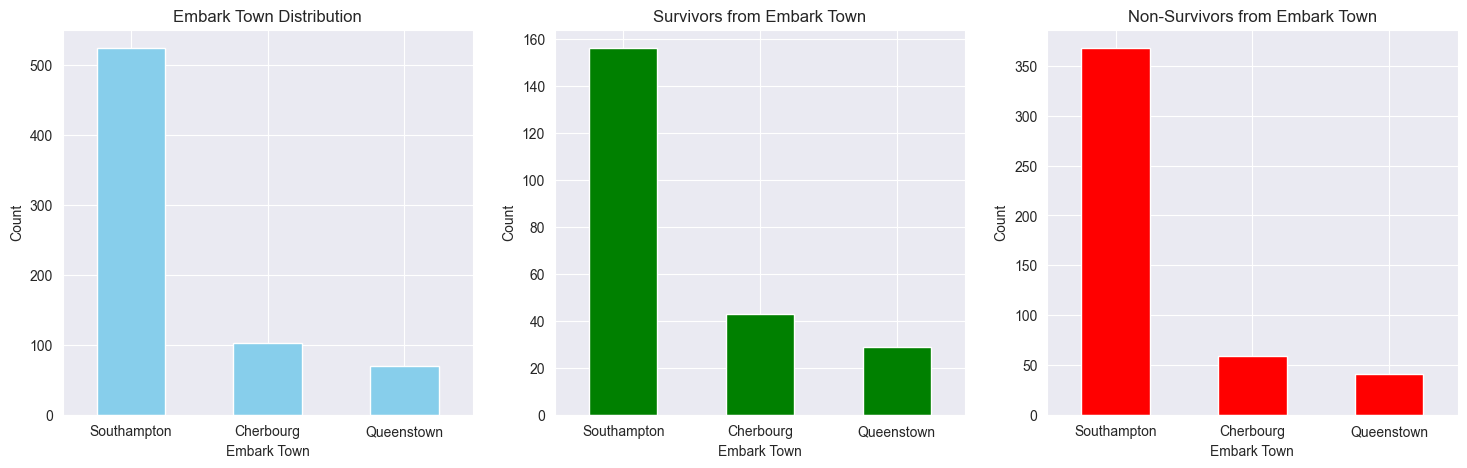

In [25]:
total_count = df["embark_town"].value_counts()
survived_count = df[df["survived"] == 1]["embark_town"].value_counts()
non_survivors_count = df[df["survived"] == 0]["embark_town"].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot total distribution
total_count.plot(kind="bar", ax=axes[0], color="skyblue", title="Embark Town Distribution")
axes[0].set_xlabel("Embark Town")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(len(total_count.index)))
axes[0].set_xticklabels(total_count.index, rotation=0)

# Plot survivors distribution
survived_count.plot(kind="bar", ax=axes[1], color="green", title="Survivors from Embark Town")
axes[1].set_xlabel("Embark Town")
axes[1].set_ylabel("Count")
axes[1].set_xticks(range(len(total_count.index)))
axes[1].set_xticklabels(total_count.index, rotation=0)

# Plot non-survivors distribution
non_survivors_count.plot(kind="bar", ax=axes[2], color="red", title="Non-Survivors from Embark Town")
axes[2].set_xlabel("Embark Town")
axes[2].set_ylabel("Count")
axes[2].set_xticks(range(len(total_count.index)))
axes[2].set_xticklabels(total_count.index, rotation=0)

plt.show()

### Feature Engineering

#### Family Size

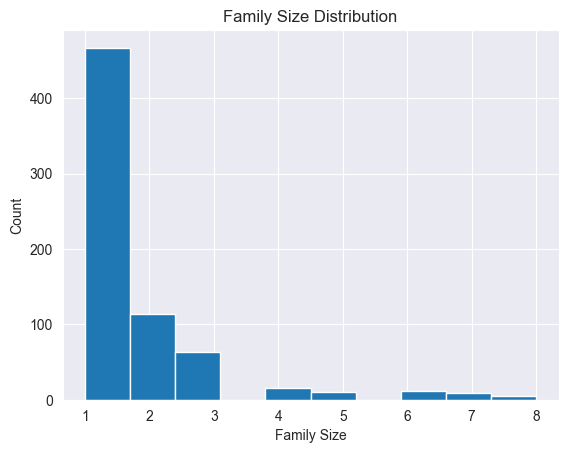

In [26]:
df["family_size"] = df["sibsp"] + df["parch"] + 1
plt.hist(df["family_size"])
plt.xlabel("Family Size")
plt.ylabel("Count")
plt.title("Family Size Distribution")
plt.show()

### Predictive Modeling

In [27]:
features = df[["age", "pclass", "fare", "sex", "who", "embark_town", "family_size"]]

In [28]:
target = df["survived"]

In [29]:
model = make_pipeline( OneHotEncoder(), SimpleImputer(), LogisticRegression())
# model = make_pipeline( OneHotEncoder(),SimpleImputer(), RandomForestClassifier())
# model = make_pipeline( OneHotEncoder(),SimpleImputer(), KNeighborsClassifier())

# model = make_pipeline( OneHotEncoder(),SimpleImputer() , SVC(kernel="linear") )


In [38]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [39]:
model.fit(X_train, y_train)

C:\Users\Shahzaib Khan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sex', 'who', 'embark_town'])),
                ('simpleimputer', SimpleImputer()),
                ('logisticregression', LogisticRegression())])

In [40]:
y_pred = model.predict(X_test)

In [41]:
print(accuracy_score(y_test, y_pred) * 100)

84.28571428571429
